# Basic Model Methods Demonstration

Comparison of Lifetime Reward (LR), Euler Residual (ER), and Bellman Residual (BR) methods on a fixed dataset.


In [1]:

import sys
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd

# Add project root to path
sys.path.append(os.path.abspath(".."))

from src.economy.data_generator import create_data_generator
from src.economy.parameters import EconomicParams, ShockParams
from src.trainers.config import NetworkConfig, OptimizationConfig, AnnealingConfig, MethodConfig, RiskyDebtConfig
from src.trainers.basic import train_basic_lr, train_basic_er, train_basic_br
from src.utils.plotting import plot_loss_comparison, plot_scenario_comparison, display_moments_table
from src.utils.analysis import evaluate_policy



/Users/wangzhaoxuan/Desktop/JPM-TSRL/DL_corp_finance/.venv/lib/python3.12/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


In [11]:

# 1. Configuration (Debug Mode)

# Economic Parameters (override on default values)
params = EconomicParams.with_overrides(
    cost_convex = 0.0,
    cost_fixed = 0.0,
    cost_inject_fixed = 0.0,
    cost_inject_linear = 0.0    
)

shock_params = ShockParams()

# Network Config (Small for speed)
net_config = NetworkConfig(
    n_layers=2,
    n_neurons=16,
    activation="swish"
)

# Optimization Config
opt_config = OptimizationConfig(
    learning_rate=1e-3,
    batch_size=128,
    n_iter=50,
    log_every=10
)

# Annealing
anneal_config = AnnealingConfig()

print("Configuration set.")

Configuration set.


In [12]:
import dataclasses
from pprint import pprint

# Comprehensive preview of the configs
print("--- Economic Parameters ---")
pprint(dataclasses.asdict(params))

print("\n--- Shock Parameters ---")
pprint(dataclasses.asdict(shock_params))

print("\n--- Network Config ---")
pprint(dataclasses.asdict(net_config))

print("\n--- Optimization Config ---")
pprint(dataclasses.asdict(opt_config))

print("\n--- Annealing Config ---")
pprint(dataclasses.asdict(anneal_config))

--- Economic Parameters ---
{'cost_convex': 0.0,
 'cost_default': 0.4,
 'cost_fixed': 0.0,
 'cost_inject_fixed': 0.0,
 'cost_inject_linear': 0.0,
 'delta': 0.15,
 'frac_liquid': 0.5,
 'r_rate': 0.04,
 'tax': 0.3,
 'theta': 0.7}

--- Shock Parameters ---
{'mu': 0.0, 'rho': 0.7, 'sigma': 0.15}

--- Network Config ---
{'activation': 'swish', 'n_layers': 2, 'n_neurons': 16}

--- Optimization Config ---
{'batch_size': 128,
 'learning_rate': 0.001,
 'learning_rate_critic': None,
 'log_every': 10,
 'n_iter': 50}

--- Annealing Config ---
{'decay': 0.9,
 'logit_clip': 20.0,
 'schedule': 'exponential',
 'temperature_init': 1.0,
 'temperature_min': 0.0001}


In [ ]:

# 2. Data Generation

# Create Generator
generator, _, bounds = create_data_generator(
    master_seed=(42, 100),
    T=128,
    sim_batch_size=64,
    n_sim_batches=50, 
    shock_params=shock_params,
    cache_dir="../data",
    save_to_disk=True,
    verbose=True
)

# Get Training Dataset (This creates/caches it)
print("Generating Training Data...")
train_data = generator.get_training_dataset()
print(f"Data Shapes: k0={train_data['k0'].shape}, z_path={train_data['z_path'].shape}")



2026-01-25 16:57:15.796883: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2026-01-25 16:57:15.796915: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2026-01-25 16:57:15.796923: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.92 GB
2026-01-25 16:57:15.796940: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2026-01-25 16:57:15.796954: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


 Using provided ShockParams
 Auto-generated missing SamplingBounds
  k_bounds: (1.8907927226966654, 1892.9403205389913)
  log_z_bounds: (-0.6301260378126043, 0.6301260378126043)
  b_bounds: (0.0, 2262.4757700180035)
  Master seed: (42, 100)
 === DataGenerator created ===
  Simulation batch size (n): 128
  Horizon (T): 128
  Simulation batches (J): 50
  Total samples: 6400
Generating Training Data...
Data Shapes: k0=(6400,), z_path=(6400, 129)



Batch 0 Summary:
------------------------------------------------------------
k0         shape=(6400,)         mean=950.6422 std=549.5942 min=2.1942 max=1892.6624
z0         shape=(6400,)         mean=1.0718 std=0.3843 min=0.5327 max=1.8774
b0         shape=(6400,)         mean=1145.9960 std=654.1934 min=0.3083 max=2262.1445
z_path     shape=(6400, 129)     mean=1.0244 std=0.2212 min=0.3769 max=2.8139
Saved z_path plot to ../data/train_data_dist_zpath.png
Saved distribution plot to ../data/train_data_dist.png


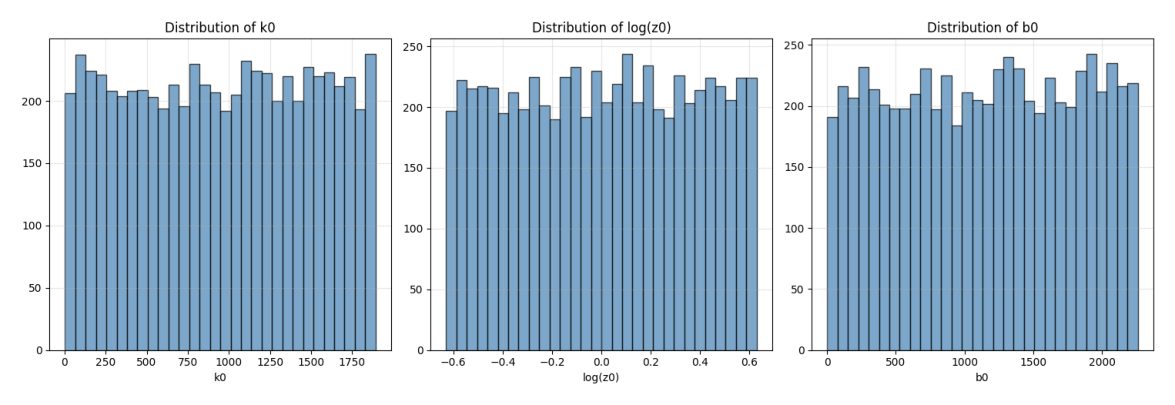

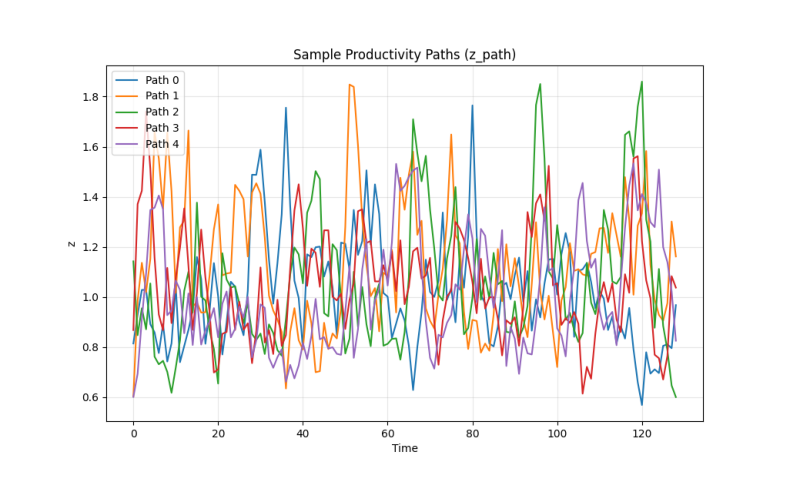

In [4]:
from src.utils.analysis import plot_dataset_stats, summarize_batch
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# 1. Print numerical stats of a single batch
summarize_batch(train_data, batch_idx=0)

# 2. Generate plots (saves to file)
# We use a temporary path for the plot
plot_path = "../data/train_data_dist.png"
plot_dataset_stats(train_data, save_path=plot_path)

# 3. Display the saved plots inline
try:
    img = mpimg.imread(plot_path)
    plt.figure(figsize=(15, 5))
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    
    # Also allow checking z_path plot if it was generated
    z_path_img = plot_path.replace(".png", "_zpath.png")
    if os.path.exists(z_path_img):
        img_z = mpimg.imread(z_path_img)
        plt.figure(figsize=(10, 6))
        plt.imshow(img_z)
        plt.axis('off')
        plt.show()
except FileNotFoundError:
    print("Plot file not found/generated.")

In [5]:

# 3. Train Lifetime Reward (LR)

method_config_lr = MethodConfig(name="basic_lr")

print("Starting LR Training...")
result_lr = train_basic_lr(
    dataset=train_data,
    net_config=net_config,
    opt_config=opt_config,
    method_config=method_config_lr,
    anneal_config=anneal_config,
    params=params,
    shock_params=shock_params,
    bounds=bounds
)
print("LR Training Complete.")



Starting LR Training...
LR Training Complete.


In [6]:

# 4. Train Euler Residual (ER)

method_config_er = MethodConfig(name="basic_er")

print("Starting ER Training...")
result_er = train_basic_er(
    dataset=train_data,
    net_config=net_config,
    opt_config=opt_config,
    method_config=method_config_er,
    anneal_config=anneal_config,
    params=params,
    shock_params=shock_params,
    bounds=bounds
)
print("ER Training Complete.")



Starting ER Training...
ER Training Complete.


In [7]:

# 5. Train Bellman Residual (BR)

method_config_br = MethodConfig(
    name="basic_br",
    n_critic=5 # 5 critic steps per actor step
)

print("Starting BR Training...")
result_br = train_basic_br(
    dataset=train_data,
    net_config=net_config,
    opt_config=opt_config,
    method_config=method_config_br,
    anneal_config=anneal_config,
    params=params,
    shock_params=shock_params,
    bounds=bounds
)
print("BR Training Complete.")



Starting BR Training...
BR Training Complete.


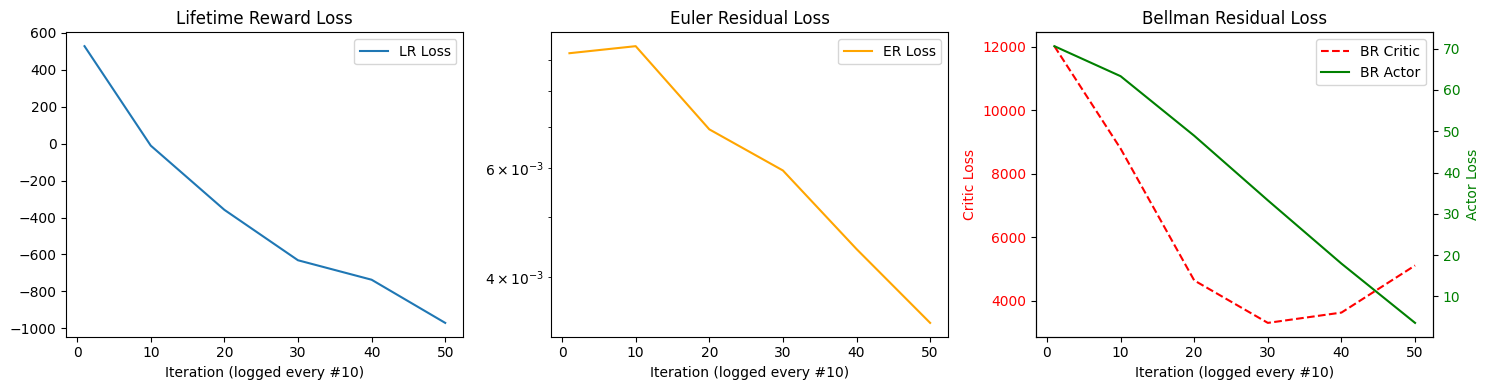

In [8]:
# 6. Loss Comparison

histories = [result_lr['history'], result_er['history'], result_br['history']]
labels = ["LR", "ER", "BR"]

# Dynamic Label
freq_str = f"Iteration (logged every #{opt_config.log_every})"

plt.figure(figsize=(15, 4))

# 1. Lifetime Reward
plt.subplot(1, 3, 1)
iter_lr = result_lr['history']['iteration']
plt.plot(iter_lr, result_lr['history']['loss_LR'], label='LR Loss')
plt.title('Lifetime Reward Loss')
plt.xlabel(freq_str)
plt.legend()

# 2. Euler Residual
plt.subplot(1, 3, 2)
iter_er = result_er['history']['iteration']
plt.plot(iter_er, result_er['history']['loss_ER'], label='ER Loss', color='orange')
plt.title('Euler Residual Loss')
plt.xlabel(freq_str)
plt.legend()
plt.yscale('log')

# 3. Bellman Residual (Dual Axis)
plt.subplot(1, 3, 3)
ax3 = plt.gca()
iter_br = result_br['history']['iteration']

# Critic on primary Y
line1 = ax3.plot(iter_br, result_br['history']['loss_critic'], label='BR Critic', color='red', linestyle='--')
ax3.set_ylabel('Critic Loss', color='red')
ax3.tick_params(axis='y', labelcolor='red')

# Actor on secondary Y
ax3b = ax3.twinx()
line2 = ax3b.plot(iter_br, result_br['history']['loss_actor'], label='BR Actor', color='green')
ax3b.set_ylabel('Actor Loss', color='green')
ax3b.tick_params(axis='y', labelcolor='green')

# Combined Legend
lines = line1 + line2
labels_box = [l.get_label() for l in lines]
ax3.legend(lines, labels_box, loc=0)

plt.title('Bellman Residual Loss')
ax3.set_xlabel(freq_str)

plt.tight_layout()
plt.show()

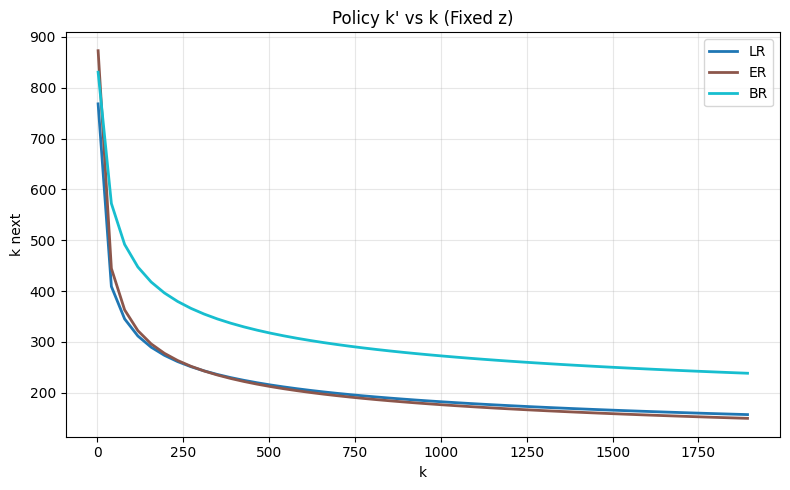

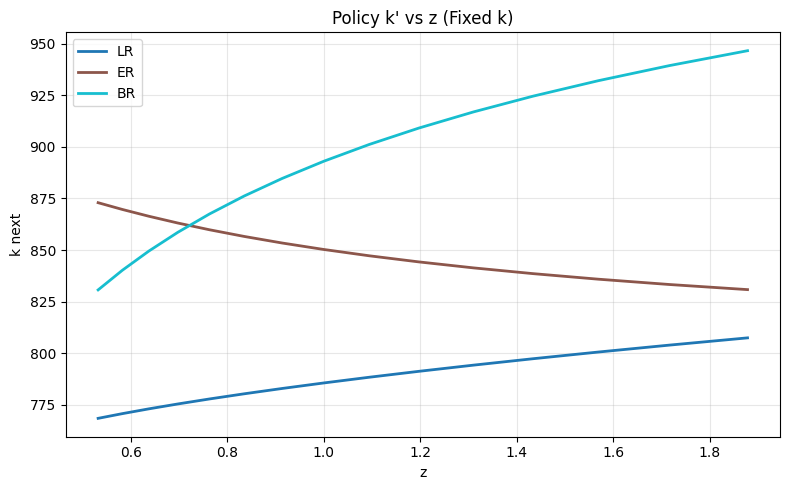

In [9]:

# 7. Policy Comparison

# Evaluate all policies on the same grid
eval_lr = evaluate_policy(result_lr['_policy_net'], bounds['k'], bounds['log_z'])
eval_er = evaluate_policy(result_er['_policy_net'], bounds['k'], bounds['log_z'])
eval_br = evaluate_policy(result_br['_policy_net'], bounds['k'], bounds['log_z'])

eval_datas = [eval_lr, eval_er, eval_br]
labels = ["LR", "ER", "BR"]

# Plot Slices
fig_k = plot_scenario_comparison(
    eval_datas, labels, x_key='k', y_key='k_next', fixed_key='fixed_z_val', 
    title="Policy k' vs k (Fixed z)"
)
plt.show()

fig_z = plot_scenario_comparison(
    eval_datas, labels, x_key='z', y_key='k_next', fixed_key='fixed_k_val', 
    title="Policy k' vs z (Fixed k)"
)
plt.show()

